# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.01614717, -0.21361875, -0.02981231,  0.30594269]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.545685983217702 -3.2670066086966054


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [28]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # returning the given data to the model
    return actions, states

In [29]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [30]:
def model_loss(actions, states, # model input
               action_size, hidden_size): # model init for Qs
        
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits[:-1], 
                                                                     labels=actions_onehot[1:]))
    
    return actions_logits, loss

In [31]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [33]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [34]:
# from collections import deque

# class Memory():    
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [35]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(9, 4) actions:(9,)
1.0


In [36]:
# Training parameters
train_episodes = 10000         # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
# batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [37]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# # Init the memory
# memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [38]:
env.reset()

array([ 0.03811717, -0.04882077,  0.04753973,  0.00604234])

In [39]:
# # Initialize the simulation
# state = env.reset()
# batch = []

# # Make a bunch of random actions and store the experiences
# for each_step in range(max_steps):
    
#     # Take one random step to get the pole and cart moving
#     action = env.action_space.sample()
#     state, _, done, _ = env.step(action)
#     reward = 1 - float(done)
#     #memory.buffer.append((action, state, reward))
#     batch.append((action, state, reward))
    
#     # End of the episodes which defines the goal of the episode/mission
#     if done is True:
#         # Start new episode
#         #env.reset()
#         break

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [40]:
state, reward, action

(array([-0.16529056, -1.76876242,  0.23176047,  2.77807856]), 0.0, 0)

In [41]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        state = env.reset() # env first state
        batch = [] # every data batch

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Get action from model
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            batch.append([action*reward, state])
            if done is True:
                break
                
        #batch = memory.buffer
        actions = np.array([each[0] for each in batch])
        states = np.array([each[1] for each in batch])
        loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                 model.states: states})
            
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(len(batch)),
              'Batch loss: {:.9f}'.format(loss))
        print('-------------------------------------------------------------------------------')
        rewards_list.append((ep, len(batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-pg.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 13 Batch loss: 0.691218615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 10 Batch loss: 0.641006649
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9 Batch loss: 0.599315166
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 9 Batch loss: 0.541315734
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4 Total reward: 10 Batch loss: 0.488366663
----------------------

-------------------------------------------------------------------------------
Episode: 42 Total reward: 9 Batch loss: 0.029400900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 43 Total reward: 10 Batch loss: 0.026644342
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 44 Total reward: 11 Batch loss: 0.020951604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 45 Total reward: 8 Batch loss: 0.024536377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 46 Total reward: 9 Batch loss: 0.025248595
------------------

-------------------------------------------------------------------------------
Episode: 84 Total reward: 8 Batch loss: 0.005820104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 85 Total reward: 11 Batch loss: 0.005326471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 86 Total reward: 10 Batch loss: 0.005949495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 87 Total reward: 10 Batch loss: 0.004655386
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 88 Total reward: 10 Batch loss: 0.004998784
----------------

-------------------------------------------------------------------------------
Episode: 123 Total reward: 10 Batch loss: 0.002686170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 124 Total reward: 10 Batch loss: 0.002472803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 125 Total reward: 8 Batch loss: 0.002482720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 126 Total reward: 9 Batch loss: 0.002035596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 127 Total reward: 9 Batch loss: 0.002415220
-------------

-------------------------------------------------------------------------------
Episode: 163 Total reward: 9 Batch loss: 0.001211873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 8 Batch loss: 0.001176139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 165 Total reward: 9 Batch loss: 0.001308493
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 9 Batch loss: 0.001145018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 10 Batch loss: 0.001255832
--------------

-------------------------------------------------------------------------------
Episode: 203 Total reward: 10 Batch loss: 0.000859440
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 204 Total reward: 9 Batch loss: 0.000874511
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 9 Batch loss: 0.000829414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 8 Batch loss: 0.000591600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 207 Total reward: 10 Batch loss: 0.000593063
-------------

-------------------------------------------------------------------------------
Episode: 245 Total reward: 8 Batch loss: 0.000482083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 10 Batch loss: 0.000447290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 9 Batch loss: 0.000527143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 248 Total reward: 9 Batch loss: 0.000406874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 249 Total reward: 9 Batch loss: 0.000484711
--------------

-------------------------------------------------------------------------------
Episode: 286 Total reward: 10 Batch loss: 0.000321109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 287 Total reward: 8 Batch loss: 0.000278722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 288 Total reward: 8 Batch loss: 0.000381721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 289 Total reward: 10 Batch loss: 0.000341607
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 290 Total reward: 9 Batch loss: 0.000427571
-------------

-------------------------------------------------------------------------------
Episode: 327 Total reward: 8 Batch loss: 0.000236710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 328 Total reward: 9 Batch loss: 0.000237721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 329 Total reward: 10 Batch loss: 0.000256980
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 330 Total reward: 10 Batch loss: 0.000214894
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 10 Batch loss: 0.000202990
------------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 9 Batch loss: 0.000172380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 9 Batch loss: 0.000201972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 8 Batch loss: 0.000174444
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 8 Batch loss: 0.000165885
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 11 Batch loss: 0.000177546
--------------

-------------------------------------------------------------------------------
Episode: 407 Total reward: 9 Batch loss: 0.000162136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 408 Total reward: 9 Batch loss: 0.000127119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 10 Batch loss: 0.000121148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 8 Batch loss: 0.000146299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 411 Total reward: 10 Batch loss: 0.000147815
-------------

-------------------------------------------------------------------------------
Episode: 448 Total reward: 9 Batch loss: 0.000084066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 8 Batch loss: 0.000120721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 10 Batch loss: 0.000123543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 10 Batch loss: 0.000090122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 452 Total reward: 10 Batch loss: 0.000137227
------------

-------------------------------------------------------------------------------
Episode: 492 Total reward: 10 Batch loss: 0.000091459
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 493 Total reward: 11 Batch loss: 0.000104149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 494 Total reward: 10 Batch loss: 0.000078565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 495 Total reward: 9 Batch loss: 0.000072732
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 496 Total reward: 10 Batch loss: 0.000080352
-----------

-------------------------------------------------------------------------------
Episode: 543 Total reward: 8 Batch loss: 0.000084789
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 544 Total reward: 10 Batch loss: 0.000076063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 545 Total reward: 10 Batch loss: 0.000058375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 546 Total reward: 8 Batch loss: 0.000082015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 547 Total reward: 9 Batch loss: 0.000072806
-------------

-------------------------------------------------------------------------------
Episode: 582 Total reward: 10 Batch loss: 0.000048325
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 583 Total reward: 9 Batch loss: 0.000050418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 584 Total reward: 9 Batch loss: 0.000055557
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 585 Total reward: 10 Batch loss: 0.000048497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 586 Total reward: 9 Batch loss: 0.000044504
-------------

-------------------------------------------------------------------------------
Episode: 623 Total reward: 10 Batch loss: 0.000055303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 624 Total reward: 11 Batch loss: 0.000046567
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 9 Batch loss: 0.000058745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 10 Batch loss: 0.000042618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 627 Total reward: 9 Batch loss: 0.000051475
------------

-------------------------------------------------------------------------------
Episode: 662 Total reward: 10 Batch loss: 0.000032699
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 663 Total reward: 9 Batch loss: 0.000058581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 664 Total reward: 10 Batch loss: 0.000034818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 665 Total reward: 10 Batch loss: 0.000047491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 666 Total reward: 10 Batch loss: 0.000042962
-----------

Episode: 701 Total reward: 9 Batch loss: 0.000034492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 9 Batch loss: 0.000029919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 9 Batch loss: 0.000030589
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 704 Total reward: 8 Batch loss: 0.000041020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 705 Total reward: 10 Batch loss: 0.000030859
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 740 Total reward: 9 Batch loss: 0.000035267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 10 Batch loss: 0.000031998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 742 Total reward: 8 Batch loss: 0.000029425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 10 Batch loss: 0.000022158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 744 Total reward: 9 Batch loss: 0.000030023
-------------

-------------------------------------------------------------------------------
Episode: 780 Total reward: 9 Batch loss: 0.000021695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 781 Total reward: 8 Batch loss: 0.000032541
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 782 Total reward: 9 Batch loss: 0.000032809
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 783 Total reward: 9 Batch loss: 0.000030664
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 784 Total reward: 10 Batch loss: 0.000030051
--------------

-------------------------------------------------------------------------------
Episode: 819 Total reward: 10 Batch loss: 0.000022529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 820 Total reward: 8 Batch loss: 0.000022393
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 821 Total reward: 10 Batch loss: 0.000018331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 822 Total reward: 10 Batch loss: 0.000026277
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 823 Total reward: 10 Batch loss: 0.000016317
-----------

-------------------------------------------------------------------------------
Episode: 860 Total reward: 8 Batch loss: 0.000022921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 861 Total reward: 10 Batch loss: 0.000017907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 862 Total reward: 11 Batch loss: 0.000027093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 863 Total reward: 9 Batch loss: 0.000026358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 864 Total reward: 8 Batch loss: 0.000024096
-------------

-------------------------------------------------------------------------------
Episode: 902 Total reward: 10 Batch loss: 0.000017430
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 10 Batch loss: 0.000019284
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 8 Batch loss: 0.000016416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 905 Total reward: 9 Batch loss: 0.000024034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 906 Total reward: 10 Batch loss: 0.000019999
------------

-------------------------------------------------------------------------------
Episode: 942 Total reward: 10 Batch loss: 0.000015549
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 943 Total reward: 9 Batch loss: 0.000016971
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 944 Total reward: 8 Batch loss: 0.000018323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 945 Total reward: 11 Batch loss: 0.000016879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 946 Total reward: 9 Batch loss: 0.000015243
-------------

-------------------------------------------------------------------------------
Episode: 983 Total reward: 11 Batch loss: 0.000013673
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 984 Total reward: 9 Batch loss: 0.000017448
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 985 Total reward: 10 Batch loss: 0.000021959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 986 Total reward: 10 Batch loss: 0.000016860
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 987 Total reward: 10 Batch loss: 0.000017801
-----------

-------------------------------------------------------------------------------
Episode: 1024 Total reward: 10 Batch loss: 0.000014410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1025 Total reward: 9 Batch loss: 0.000011578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1026 Total reward: 10 Batch loss: 0.000016251
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1027 Total reward: 10 Batch loss: 0.000014225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1028 Total reward: 10 Batch loss: 0.000015430
------

-------------------------------------------------------------------------------
Episode: 1067 Total reward: 10 Batch loss: 0.000012609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1068 Total reward: 9 Batch loss: 0.000011086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1069 Total reward: 10 Batch loss: 0.000012967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1070 Total reward: 9 Batch loss: 0.000014766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1071 Total reward: 9 Batch loss: 0.000012233
--------

-------------------------------------------------------------------------------
Episode: 1108 Total reward: 10 Batch loss: 0.000012463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1109 Total reward: 10 Batch loss: 0.000008464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1110 Total reward: 10 Batch loss: 0.000013523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1111 Total reward: 10 Batch loss: 0.000012728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1112 Total reward: 8 Batch loss: 0.000010507
------

-------------------------------------------------------------------------------
Episode: 1151 Total reward: 8 Batch loss: 0.000009179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1152 Total reward: 9 Batch loss: 0.000012531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1153 Total reward: 10 Batch loss: 0.000009722
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1154 Total reward: 8 Batch loss: 0.000009366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 8 Batch loss: 0.000011750
---------

-------------------------------------------------------------------------------
Episode: 1191 Total reward: 10 Batch loss: 0.000007881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1192 Total reward: 11 Batch loss: 0.000011312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1193 Total reward: 10 Batch loss: 0.000009232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1194 Total reward: 10 Batch loss: 0.000008053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1195 Total reward: 9 Batch loss: 0.000009969
------

-------------------------------------------------------------------------------
Episode: 1230 Total reward: 8 Batch loss: 0.000008225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1231 Total reward: 9 Batch loss: 0.000010922
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1232 Total reward: 9 Batch loss: 0.000009834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1233 Total reward: 8 Batch loss: 0.000008804
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1234 Total reward: 10 Batch loss: 0.000008265
---------

-------------------------------------------------------------------------------
Episode: 1271 Total reward: 10 Batch loss: 0.000006755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1272 Total reward: 9 Batch loss: 0.000009790
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1273 Total reward: 10 Batch loss: 0.000008013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1274 Total reward: 10 Batch loss: 0.000009338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1275 Total reward: 9 Batch loss: 0.000006303
-------

-------------------------------------------------------------------------------
Episode: 1313 Total reward: 8 Batch loss: 0.000007033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1314 Total reward: 10 Batch loss: 0.000007431
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 9 Batch loss: 0.000006005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1316 Total reward: 10 Batch loss: 0.000008543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1317 Total reward: 9 Batch loss: 0.000007346
--------

-------------------------------------------------------------------------------
Episode: 1356 Total reward: 10 Batch loss: 0.000007709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1357 Total reward: 8 Batch loss: 0.000007578
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1358 Total reward: 9 Batch loss: 0.000008151
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1359 Total reward: 8 Batch loss: 0.000007782
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1360 Total reward: 10 Batch loss: 0.000007298
--------

-------------------------------------------------------------------------------
Episode: 1406 Total reward: 9 Batch loss: 0.000005469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1407 Total reward: 9 Batch loss: 0.000004962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 9 Batch loss: 0.000006482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 9 Batch loss: 0.000007391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1410 Total reward: 9 Batch loss: 0.000005618
----------

-------------------------------------------------------------------------------
Episode: 1446 Total reward: 8 Batch loss: 0.000004785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1447 Total reward: 9 Batch loss: 0.000007033
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1448 Total reward: 10 Batch loss: 0.000005391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1449 Total reward: 9 Batch loss: 0.000005469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1450 Total reward: 9 Batch loss: 0.000006586
---------

-------------------------------------------------------------------------------
Episode: 1486 Total reward: 9 Batch loss: 0.000004411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1487 Total reward: 9 Batch loss: 0.000006005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1488 Total reward: 9 Batch loss: 0.000005111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1489 Total reward: 9 Batch loss: 0.000005275
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1490 Total reward: 10 Batch loss: 0.000004437
---------

-------------------------------------------------------------------------------
Episode: 1525 Total reward: 9 Batch loss: 0.000005186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1526 Total reward: 10 Batch loss: 0.000007391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1527 Total reward: 10 Batch loss: 0.000006464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1528 Total reward: 10 Batch loss: 0.000006146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1529 Total reward: 9 Batch loss: 0.000004798
-------

-------------------------------------------------------------------------------
Episode: 1566 Total reward: 10 Batch loss: 0.000006106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1567 Total reward: 8 Batch loss: 0.000005909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1568 Total reward: 9 Batch loss: 0.000004336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 9 Batch loss: 0.000005305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 10 Batch loss: 0.000005378
--------

-------------------------------------------------------------------------------
Episode: 1612 Total reward: 8 Batch loss: 0.000005586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1613 Total reward: 9 Batch loss: 0.000004530
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1614 Total reward: 9 Batch loss: 0.000004917
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 9 Batch loss: 0.000003770
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 9 Batch loss: 0.000003651
----------

-------------------------------------------------------------------------------
Episode: 1656 Total reward: 9 Batch loss: 0.000002965
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1657 Total reward: 10 Batch loss: 0.000005391
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1658 Total reward: 9 Batch loss: 0.000003934
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1659 Total reward: 8 Batch loss: 0.000004411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1660 Total reward: 9 Batch loss: 0.000003815
---------

-------------------------------------------------------------------------------
Episode: 1707 Total reward: 10 Batch loss: 0.000004027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 8 Batch loss: 0.000003048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward: 10 Batch loss: 0.000003775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1710 Total reward: 9 Batch loss: 0.000003830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1711 Total reward: 10 Batch loss: 0.000004861
-------

-------------------------------------------------------------------------------
Episode: 1752 Total reward: 10 Batch loss: 0.000002278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1753 Total reward: 10 Batch loss: 0.000003232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1754 Total reward: 9 Batch loss: 0.000004232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1755 Total reward: 11 Batch loss: 0.000004232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1756 Total reward: 10 Batch loss: 0.000004212
------

Episode: 1793 Total reward: 8 Batch loss: 0.000002929
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1794 Total reward: 8 Batch loss: 0.000004070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1795 Total reward: 9 Batch loss: 0.000003070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1796 Total reward: 10 Batch loss: 0.000003987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1797 Total reward: 10 Batch loss: 0.000004715
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 1839 Total reward: 10 Batch loss: 0.000002517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1840 Total reward: 10 Batch loss: 0.000003629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1841 Total reward: 8 Batch loss: 0.000003491
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1842 Total reward: 10 Batch loss: 0.000002861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1843 Total reward: 9 Batch loss: 0.000002697
-------

-------------------------------------------------------------------------------
Episode: 1881 Total reward: 9 Batch loss: 0.000002816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1882 Total reward: 10 Batch loss: 0.000003179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1883 Total reward: 9 Batch loss: 0.000003129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1884 Total reward: 10 Batch loss: 0.000004133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1885 Total reward: 9 Batch loss: 0.000003934
--------

-------------------------------------------------------------------------------
Episode: 1924 Total reward: 9 Batch loss: 0.000003949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1925 Total reward: 9 Batch loss: 0.000002399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1926 Total reward: 9 Batch loss: 0.000003949
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1927 Total reward: 10 Batch loss: 0.000002397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1928 Total reward: 10 Batch loss: 0.000003775
--------

-------------------------------------------------------------------------------
Episode: 1966 Total reward: 9 Batch loss: 0.000002131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 8 Batch loss: 0.000004104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 9 Batch loss: 0.000002950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1969 Total reward: 10 Batch loss: 0.000002358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1970 Total reward: 10 Batch loss: 0.000003113
--------

-------------------------------------------------------------------------------
Episode: 2007 Total reward: 10 Batch loss: 0.000002570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2008 Total reward: 9 Batch loss: 0.000003085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2009 Total reward: 10 Batch loss: 0.000002662
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2010 Total reward: 10 Batch loss: 0.000003669
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2011 Total reward: 9 Batch loss: 0.000002503
-------

-------------------------------------------------------------------------------
Episode: 2047 Total reward: 10 Batch loss: 0.000003086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2048 Total reward: 10 Batch loss: 0.000002344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2049 Total reward: 10 Batch loss: 0.000002676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2050 Total reward: 9 Batch loss: 0.000002637
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2051 Total reward: 9 Batch loss: 0.000002354
-------

-------------------------------------------------------------------------------
Episode: 2089 Total reward: 10 Batch loss: 0.000002093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2090 Total reward: 11 Batch loss: 0.000003087
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2091 Total reward: 9 Batch loss: 0.000002682
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2092 Total reward: 10 Batch loss: 0.000002570
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2093 Total reward: 9 Batch loss: 0.000002220
-------

-------------------------------------------------------------------------------
Episode: 2130 Total reward: 10 Batch loss: 0.000001748
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2131 Total reward: 8 Batch loss: 0.000002367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2132 Total reward: 10 Batch loss: 0.000002146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2133 Total reward: 9 Batch loss: 0.000001773
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2134 Total reward: 10 Batch loss: 0.000003099
-------

-------------------------------------------------------------------------------
Episode: 2173 Total reward: 10 Batch loss: 0.000001881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2174 Total reward: 8 Batch loss: 0.000002197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2175 Total reward: 9 Batch loss: 0.000002742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2176 Total reward: 8 Batch loss: 0.000002912
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2177 Total reward: 10 Batch loss: 0.000001894
--------

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2216 Total reward: 8 Batch loss: 0.000002469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2217 Total reward: 8 Batch loss: 0.000001618
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2218 Total reward: 9 Batch loss: 0.000002712
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2219 Total reward: 9 Batch loss: 0.000002488
-------------------------------------------------------------------------------
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 2260 Total reward: 9 Batch loss: 0.000001565
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2261 Total reward: 10 Batch loss: 0.000001921
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2262 Total reward: 10 Batch loss: 0.000002424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2263 Total reward: 10 Batch loss: 0.000001629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2264 Total reward: 8 Batch loss: 0.000001635
-------

-------------------------------------------------------------------------------
Episode: 2309 Total reward: 10 Batch loss: 0.000001695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2310 Total reward: 10 Batch loss: 0.000001788
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2311 Total reward: 10 Batch loss: 0.000001576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2312 Total reward: 9 Batch loss: 0.000001520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2313 Total reward: 10 Batch loss: 0.000002437
------

-------------------------------------------------------------------------------
Episode: 2353 Total reward: 10 Batch loss: 0.000001762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2354 Total reward: 9 Batch loss: 0.000002146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2355 Total reward: 10 Batch loss: 0.000001192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2356 Total reward: 10 Batch loss: 0.000001616
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2357 Total reward: 10 Batch loss: 0.000001907
------

-------------------------------------------------------------------------------
Episode: 2398 Total reward: 10 Batch loss: 0.000002106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2399 Total reward: 10 Batch loss: 0.000002225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2400 Total reward: 10 Batch loss: 0.000001497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2401 Total reward: 9 Batch loss: 0.000001058
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2402 Total reward: 10 Batch loss: 0.000001589
------

-------------------------------------------------------------------------------
Episode: 2439 Total reward: 9 Batch loss: 0.000001445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2440 Total reward: 9 Batch loss: 0.000001520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2441 Total reward: 10 Batch loss: 0.000001205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2442 Total reward: 10 Batch loss: 0.000001576
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2443 Total reward: 10 Batch loss: 0.000001656
-------

-------------------------------------------------------------------------------
Episode: 2484 Total reward: 10 Batch loss: 0.000001285
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2485 Total reward: 9 Batch loss: 0.000001729
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2486 Total reward: 10 Batch loss: 0.000001020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2487 Total reward: 9 Batch loss: 0.000001609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2488 Total reward: 9 Batch loss: 0.000001252
--------

-------------------------------------------------------------------------------
Episode: 2533 Total reward: 9 Batch loss: 0.000001118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2534 Total reward: 9 Batch loss: 0.000002235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2535 Total reward: 9 Batch loss: 0.000001192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2536 Total reward: 9 Batch loss: 0.000001445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2537 Total reward: 10 Batch loss: 0.000001166
---------

-------------------------------------------------------------------------------
Episode: 2580 Total reward: 10 Batch loss: 0.000001086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2581 Total reward: 10 Batch loss: 0.000001272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2582 Total reward: 11 Batch loss: 0.000000966
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2583 Total reward: 9 Batch loss: 0.000001445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2584 Total reward: 9 Batch loss: 0.000001162
-------

-------------------------------------------------------------------------------
Episode: 2623 Total reward: 9 Batch loss: 0.000001281
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2624 Total reward: 9 Batch loss: 0.000002056
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2625 Total reward: 9 Batch loss: 0.000001013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2626 Total reward: 10 Batch loss: 0.000001523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2627 Total reward: 9 Batch loss: 0.000001505
---------

-------------------------------------------------------------------------------
Episode: 2667 Total reward: 9 Batch loss: 0.000001594
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2668 Total reward: 9 Batch loss: 0.000001162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2669 Total reward: 9 Batch loss: 0.000001252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2670 Total reward: 10 Batch loss: 0.000001205
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2671 Total reward: 11 Batch loss: 0.000001395
--------

-------------------------------------------------------------------------------
Episode: 2713 Total reward: 10 Batch loss: 0.000001497
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2714 Total reward: 10 Batch loss: 0.000001272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2715 Total reward: 8 Batch loss: 0.000001073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2716 Total reward: 10 Batch loss: 0.000000861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2717 Total reward: 8 Batch loss: 0.000001362
-------

-------------------------------------------------------------------------------
Episode: 2757 Total reward: 10 Batch loss: 0.000001510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2758 Total reward: 11 Batch loss: 0.000001466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2759 Total reward: 9 Batch loss: 0.000001132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2760 Total reward: 10 Batch loss: 0.000001126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2761 Total reward: 9 Batch loss: 0.000000969
-------

-------------------------------------------------------------------------------
Episode: 2799 Total reward: 10 Batch loss: 0.000000967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2800 Total reward: 9 Batch loss: 0.000000909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2801 Total reward: 9 Batch loss: 0.000000969
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2802 Total reward: 9 Batch loss: 0.000000745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2803 Total reward: 8 Batch loss: 0.000001260
---------

-------------------------------------------------------------------------------
Episode: 2840 Total reward: 8 Batch loss: 0.000000988
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2841 Total reward: 10 Batch loss: 0.000001311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2842 Total reward: 8 Batch loss: 0.000001073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2843 Total reward: 8 Batch loss: 0.000001107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2844 Total reward: 10 Batch loss: 0.000001099
--------

-------------------------------------------------------------------------------
Episode: 2884 Total reward: 9 Batch loss: 0.000001177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2885 Total reward: 10 Batch loss: 0.000001258
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2886 Total reward: 8 Batch loss: 0.000001158
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2887 Total reward: 9 Batch loss: 0.000001073
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2888 Total reward: 10 Batch loss: 0.000000702
--------

-------------------------------------------------------------------------------
Episode: 2929 Total reward: 11 Batch loss: 0.000001311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2930 Total reward: 10 Batch loss: 0.000000967
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2931 Total reward: 10 Batch loss: 0.000000901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2932 Total reward: 9 Batch loss: 0.000001162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2933 Total reward: 10 Batch loss: 0.000001166
------

-------------------------------------------------------------------------------
Episode: 2972 Total reward: 10 Batch loss: 0.000000848
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2973 Total reward: 8 Batch loss: 0.000000851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2974 Total reward: 8 Batch loss: 0.000000783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2975 Total reward: 10 Batch loss: 0.000000649
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2976 Total reward: 8 Batch loss: 0.000000613
--------

-------------------------------------------------------------------------------
Episode: 3015 Total reward: 10 Batch loss: 0.000000927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3016 Total reward: 11 Batch loss: 0.000000691
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3017 Total reward: 9 Batch loss: 0.000000596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3018 Total reward: 8 Batch loss: 0.000000851
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3019 Total reward: 10 Batch loss: 0.000000980
-------

-------------------------------------------------------------------------------
Episode: 3057 Total reward: 9 Batch loss: 0.000000879
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3058 Total reward: 10 Batch loss: 0.000000742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3059 Total reward: 10 Batch loss: 0.000000742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3060 Total reward: 9 Batch loss: 0.000000834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3061 Total reward: 8 Batch loss: 0.000000817
--------

-------------------------------------------------------------------------------
Episode: 3099 Total reward: 10 Batch loss: 0.000000543
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3100 Total reward: 9 Batch loss: 0.000000760
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3101 Total reward: 9 Batch loss: 0.000000700
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3102 Total reward: 9 Batch loss: 0.000000641
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3103 Total reward: 10 Batch loss: 0.000000623
--------

-------------------------------------------------------------------------------
Episode: 3141 Total reward: 10 Batch loss: 0.000000676
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3142 Total reward: 8 Batch loss: 0.000000681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3143 Total reward: 11 Batch loss: 0.000000596
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3144 Total reward: 10 Batch loss: 0.000000623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3145 Total reward: 9 Batch loss: 0.000000685
-------

-------------------------------------------------------------------------------
Episode: 3189 Total reward: 10 Batch loss: 0.000000781
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3190 Total reward: 8 Batch loss: 0.000000937
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3191 Total reward: 10 Batch loss: 0.000000768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3192 Total reward: 9 Batch loss: 0.000000715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3193 Total reward: 10 Batch loss: 0.000000689
-------

-------------------------------------------------------------------------------
Episode: 3234 Total reward: 9 Batch loss: 0.000000939
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3235 Total reward: 10 Batch loss: 0.000000623
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3236 Total reward: 10 Batch loss: 0.000000728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3237 Total reward: 9 Batch loss: 0.000000671
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3238 Total reward: 10 Batch loss: 0.000000649
-------

-------------------------------------------------------------------------------
Episode: 3284 Total reward: 9 Batch loss: 0.000000656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3285 Total reward: 10 Batch loss: 0.000000556
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3286 Total reward: 9 Batch loss: 0.000000775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3287 Total reward: 10 Batch loss: 0.000000742
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3288 Total reward: 11 Batch loss: 0.000000608
-------

-------------------------------------------------------------------------------
Episode: 3333 Total reward: 9 Batch loss: 0.000000402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3334 Total reward: 10 Batch loss: 0.000000808
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3335 Total reward: 10 Batch loss: 0.000000437
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3336 Total reward: 9 Batch loss: 0.000000909
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3337 Total reward: 9 Batch loss: 0.000000715
--------

-------------------------------------------------------------------------------
Episode: 3378 Total reward: 10 Batch loss: 0.000000384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3379 Total reward: 11 Batch loss: 0.000000703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3380 Total reward: 9 Batch loss: 0.000000566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3381 Total reward: 10 Batch loss: 0.000000517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3382 Total reward: 10 Batch loss: 0.000000503
------

-------------------------------------------------------------------------------
Episode: 3421 Total reward: 9 Batch loss: 0.000000522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3422 Total reward: 10 Batch loss: 0.000000517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3423 Total reward: 8 Batch loss: 0.000000783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3424 Total reward: 10 Batch loss: 0.000000517
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3425 Total reward: 8 Batch loss: 0.000000732
--------

-------------------------------------------------------------------------------
Episode: 3466 Total reward: 9 Batch loss: 0.000000566
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3467 Total reward: 9 Batch loss: 0.000000492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3468 Total reward: 9 Batch loss: 0.000000551
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3469 Total reward: 9 Batch loss: 0.000000522
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3470 Total reward: 10 Batch loss: 0.000000583
---------

-------------------------------------------------------------------------------
Episode: 3511 Total reward: 10 Batch loss: 0.000000728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3512 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3513 Total reward: 9 Batch loss: 0.000000462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3514 Total reward: 9 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3515 Total reward: 8 Batch loss: 0.000000392
--------

-------------------------------------------------------------------------------
Episode: 3554 Total reward: 10 Batch loss: 0.000000583
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3555 Total reward: 9 Batch loss: 0.000000715
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3556 Total reward: 10 Batch loss: 0.000000464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3557 Total reward: 10 Batch loss: 0.000000397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3558 Total reward: 10 Batch loss: 0.000000464
------

-------------------------------------------------------------------------------
Episode: 3599 Total reward: 9 Batch loss: 0.000000611
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3600 Total reward: 10 Batch loss: 0.000000384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3601 Total reward: 8 Batch loss: 0.000000630
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3602 Total reward: 8 Batch loss: 0.000000392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3603 Total reward: 10 Batch loss: 0.000000371
--------

-------------------------------------------------------------------------------
Episode: 3646 Total reward: 10 Batch loss: 0.000000464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3647 Total reward: 8 Batch loss: 0.000000409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3648 Total reward: 8 Batch loss: 0.000000409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3649 Total reward: 9 Batch loss: 0.000000581
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3650 Total reward: 9 Batch loss: 0.000000522
---------

-------------------------------------------------------------------------------
Episode: 3692 Total reward: 10 Batch loss: 0.000000278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3693 Total reward: 8 Batch loss: 0.000000392
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3694 Total reward: 10 Batch loss: 0.000000331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3695 Total reward: 10 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3696 Total reward: 9 Batch loss: 0.000000492
-------

-------------------------------------------------------------------------------
Episode: 3736 Total reward: 10 Batch loss: 0.000000503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3737 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3738 Total reward: 9 Batch loss: 0.000000432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3739 Total reward: 10 Batch loss: 0.000000371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3740 Total reward: 10 Batch loss: 0.000000490
------

-------------------------------------------------------------------------------
Episode: 3782 Total reward: 9 Batch loss: 0.000000447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3783 Total reward: 10 Batch loss: 0.000000609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3784 Total reward: 8 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3785 Total reward: 10 Batch loss: 0.000000424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3786 Total reward: 10 Batch loss: 0.000000424
-------

-------------------------------------------------------------------------------
Episode: 3828 Total reward: 8 Batch loss: 0.000000290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3829 Total reward: 9 Batch loss: 0.000000432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3830 Total reward: 10 Batch loss: 0.000000464
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3831 Total reward: 8 Batch loss: 0.000000409
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3832 Total reward: 9 Batch loss: 0.000000402
---------

-------------------------------------------------------------------------------
Episode: 3871 Total reward: 10 Batch loss: 0.000000344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3872 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3873 Total reward: 10 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3874 Total reward: 9 Batch loss: 0.000000313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3875 Total reward: 10 Batch loss: 0.000000358
------

-------------------------------------------------------------------------------
Episode: 3914 Total reward: 8 Batch loss: 0.000000460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3915 Total reward: 10 Batch loss: 0.000000331
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3916 Total reward: 9 Batch loss: 0.000000313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3917 Total reward: 10 Batch loss: 0.000000371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3918 Total reward: 8 Batch loss: 0.000000392
--------

-------------------------------------------------------------------------------
Episode: 3961 Total reward: 10 Batch loss: 0.000000344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3962 Total reward: 8 Batch loss: 0.000000307
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3963 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3964 Total reward: 9 Batch loss: 0.000000328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3965 Total reward: 9 Batch loss: 0.000000358
---------

-------------------------------------------------------------------------------
Episode: 4004 Total reward: 9 Batch loss: 0.000000507
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4005 Total reward: 9 Batch loss: 0.000000477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4006 Total reward: 9 Batch loss: 0.000000328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4007 Total reward: 8 Batch loss: 0.000000290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4008 Total reward: 9 Batch loss: 0.000000447
----------

-------------------------------------------------------------------------------
Episode: 4047 Total reward: 10 Batch loss: 0.000000265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4048 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4049 Total reward: 9 Batch loss: 0.000000536
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4050 Total reward: 9 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4051 Total reward: 8 Batch loss: 0.000000375
---------

-------------------------------------------------------------------------------
Episode: 4094 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4095 Total reward: 9 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4096 Total reward: 10 Batch loss: 0.000000450
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4097 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4098 Total reward: 9 Batch loss: 0.000000238
--------

-------------------------------------------------------------------------------
Episode: 4141 Total reward: 9 Batch loss: 0.000000373
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4142 Total reward: 9 Batch loss: 0.000000432
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4143 Total reward: 10 Batch loss: 0.000000305
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4144 Total reward: 9 Batch loss: 0.000000358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4145 Total reward: 8 Batch loss: 0.000000221
---------

Episode: 4188 Total reward: 10 Batch loss: 0.000000411
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4189 Total reward: 10 Batch loss: 0.000000291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4190 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4191 Total reward: 8 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4192 Total reward: 10 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------

-------------------------------------------------------------------------------
Episode: 4238 Total reward: 10 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4239 Total reward: 9 Batch loss: 0.000000417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4240 Total reward: 9 Batch loss: 0.000000313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4241 Total reward: 8 Batch loss: 0.000000426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4242 Total reward: 9 Batch loss: 0.000000253
---------

-------------------------------------------------------------------------------
Episode: 4283 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4284 Total reward: 10 Batch loss: 0.000000278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4285 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4286 Total reward: 9 Batch loss: 0.000000298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4287 Total reward: 9 Batch loss: 0.000000238
--------

-------------------------------------------------------------------------------
Episode: 4329 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4330 Total reward: 10 Batch loss: 0.000000291
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4331 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4332 Total reward: 10 Batch loss: 0.000000318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4333 Total reward: 9 Batch loss: 0.000000313
-------

-------------------------------------------------------------------------------
Episode: 4371 Total reward: 9 Batch loss: 0.000000283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4372 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4373 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4374 Total reward: 10 Batch loss: 0.000000252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4375 Total reward: 9 Batch loss: 0.000000238
--------

-------------------------------------------------------------------------------
Episode: 4414 Total reward: 9 Batch loss: 0.000000313
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4415 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4416 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4417 Total reward: 8 Batch loss: 0.000000272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4418 Total reward: 9 Batch loss: 0.000000224
----------

-------------------------------------------------------------------------------
Episode: 4454 Total reward: 10 Batch loss: 0.000000318
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4455 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4456 Total reward: 8 Batch loss: 0.000000290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4457 Total reward: 8 Batch loss: 0.000000272
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4458 Total reward: 11 Batch loss: 0.000000346
--------

-------------------------------------------------------------------------------
Episode: 4497 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4498 Total reward: 8 Batch loss: 0.000000290
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4499 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4500 Total reward: 8 Batch loss: 0.000000221
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4501 Total reward: 9 Batch loss: 0.000000209
---------

-------------------------------------------------------------------------------
Episode: 4540 Total reward: 9 Batch loss: 0.000000253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4541 Total reward: 10 Batch loss: 0.000000278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4542 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4543 Total reward: 10 Batch loss: 0.000000252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4544 Total reward: 10 Batch loss: 0.000000238
-------

-------------------------------------------------------------------------------
Episode: 4583 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4584 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4585 Total reward: 11 Batch loss: 0.000000310
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4586 Total reward: 10 Batch loss: 0.000000278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4587 Total reward: 10 Batch loss: 0.000000252
-----

-------------------------------------------------------------------------------
Episode: 4625 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4626 Total reward: 9 Batch loss: 0.000000328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4627 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4628 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4629 Total reward: 9 Batch loss: 0.000000328
---------

-------------------------------------------------------------------------------
Episode: 4669 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4670 Total reward: 10 Batch loss: 0.000000225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4671 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4672 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4673 Total reward: 10 Batch loss: 0.000000291
------

-------------------------------------------------------------------------------
Episode: 4713 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4714 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4715 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4716 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4717 Total reward: 10 Batch loss: 0.000000159
------

-------------------------------------------------------------------------------
Episode: 4758 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4759 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4760 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4761 Total reward: 8 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4762 Total reward: 8 Batch loss: 0.000000238
---------

-------------------------------------------------------------------------------
Episode: 4802 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4803 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4804 Total reward: 9 Batch loss: 0.000000268
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4805 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4806 Total reward: 8 Batch loss: 0.000000153
---------

-------------------------------------------------------------------------------
Episode: 4848 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4849 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4850 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4851 Total reward: 10 Batch loss: 0.000000212
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4852 Total reward: 8 Batch loss: 0.000000153
------

-------------------------------------------------------------------------------
Episode: 4896 Total reward: 10 Batch loss: 0.000000199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4897 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4898 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4899 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4900 Total reward: 10 Batch loss: 0.000000146
--------

-------------------------------------------------------------------------------
Episode: 4940 Total reward: 8 Batch loss: 0.000000187
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4941 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4942 Total reward: 8 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4943 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4944 Total reward: 8 Batch loss: 0.000000170
--------

-------------------------------------------------------------------------------
Episode: 4981 Total reward: 9 Batch loss: 0.000000238
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4982 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4983 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4984 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4985 Total reward: 9 Batch loss: 0.000000104
--------

-------------------------------------------------------------------------------
Episode: 5025 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5026 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5027 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5028 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5029 Total reward: 10 Batch loss: 0.000000106
-----

-------------------------------------------------------------------------------
Episode: 5068 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5069 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5070 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5071 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5072 Total reward: 8 Batch loss: 0.000000102
---------

-------------------------------------------------------------------------------
Episode: 5110 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5111 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5112 Total reward: 8 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5113 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5114 Total reward: 8 Batch loss: 0.000000238
-------

-------------------------------------------------------------------------------
Episode: 5152 Total reward: 8 Batch loss: 0.000000153
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5153 Total reward: 8 Batch loss: 0.000000204
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5154 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5155 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5156 Total reward: 10 Batch loss: 0.000000132
--------

Episode: 5198 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5199 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5200 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5201 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5202 Total reward: 10 Batch loss: 0.000000172
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 5239 Total reward: 9 Batch loss: 0.000000179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5240 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5241 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5242 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5243 Total reward: 9 Batch loss: 0.000000104
---------

-------------------------------------------------------------------------------
Episode: 5280 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5281 Total reward: 8 Batch loss: 0.000000102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5282 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5283 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5284 Total reward: 8 Batch loss: 0.000000136
--------

-------------------------------------------------------------------------------
Episode: 5324 Total reward: 10 Batch loss: 0.000000132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5325 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5326 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5327 Total reward: 9 Batch loss: 0.000000209
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5328 Total reward: 10 Batch loss: 0.000000106
--------

-------------------------------------------------------------------------------
Episode: 5367 Total reward: 9 Batch loss: 0.000000194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5368 Total reward: 8 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5369 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5370 Total reward: 9 Batch loss: 0.000000134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5371 Total reward: 10 Batch loss: 0.000000132
---------

-------------------------------------------------------------------------------
Episode: 5410 Total reward: 10 Batch loss: 0.000000185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5411 Total reward: 10 Batch loss: 0.000000106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5412 Total reward: 10 Batch loss: 0.000000159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5413 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5414 Total reward: 10 Batch loss: 0.000000106
------

-------------------------------------------------------------------------------
Episode: 5454 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5455 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5456 Total reward: 11 Batch loss: 0.000000167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5457 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5458 Total reward: 10 Batch loss: 0.000000159
--------

-------------------------------------------------------------------------------
Episode: 5497 Total reward: 8 Batch loss: 0.000000136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5498 Total reward: 8 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5499 Total reward: 10 Batch loss: 0.000000146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5500 Total reward: 9 Batch loss: 0.000000149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5501 Total reward: 10 Batch loss: 0.000000093
--------

-------------------------------------------------------------------------------
Episode: 5543 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5544 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5545 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5546 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5547 Total reward: 8 Batch loss: 0.000000119
--------

-------------------------------------------------------------------------------
Episode: 5585 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5586 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5587 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5588 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5589 Total reward: 9 Batch loss: 0.000000075
--------

-------------------------------------------------------------------------------
Episode: 5629 Total reward: 8 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5630 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5631 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5632 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5633 Total reward: 10 Batch loss: 0.000000093
-------

-------------------------------------------------------------------------------
Episode: 5671 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5672 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5673 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5674 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5675 Total reward: 9 Batch loss: 0.000000119
--------

-------------------------------------------------------------------------------
Episode: 5711 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5712 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5713 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5714 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5715 Total reward: 9 Batch loss: 0.000000149
---------

-------------------------------------------------------------------------------
Episode: 5754 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5755 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5756 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5757 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5758 Total reward: 10 Batch loss: 0.000000066
-------

-------------------------------------------------------------------------------
Episode: 5799 Total reward: 9 Batch loss: 0.000000164
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5800 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5801 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5802 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5803 Total reward: 9 Batch loss: 0.000000089
-------

-------------------------------------------------------------------------------
Episode: 5841 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5842 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5843 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5844 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5845 Total reward: 10 Batch loss: 0.000000079
--------

-------------------------------------------------------------------------------
Episode: 5882 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5883 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5884 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5885 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5886 Total reward: 9 Batch loss: 0.000000075
---------

-------------------------------------------------------------------------------
Episode: 5923 Total reward: 11 Batch loss: 0.000000083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5924 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5925 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5926 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5927 Total reward: 8 Batch loss: 0.000000051
-------

-------------------------------------------------------------------------------
Episode: 5966 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5967 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5968 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5969 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5970 Total reward: 10 Batch loss: 0.000000079
---------

-------------------------------------------------------------------------------
Episode: 6010 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6011 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6012 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6013 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6014 Total reward: 10 Batch loss: 0.000000079
-------

-------------------------------------------------------------------------------
Episode: 6058 Total reward: 11 Batch loss: 0.000000083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6059 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6060 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6061 Total reward: 11 Batch loss: 0.000000072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6062 Total reward: 8 Batch loss: 0.000000068
-------

-------------------------------------------------------------------------------
Episode: 6105 Total reward: 10 Batch loss: 0.000000079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6106 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6107 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6108 Total reward: 9 Batch loss: 0.000000119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6109 Total reward: 10 Batch loss: 0.000000053
-------

-------------------------------------------------------------------------------
Episode: 6149 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6150 Total reward: 8 Batch loss: 0.000000085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6151 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6152 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6153 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 6198 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6199 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6200 Total reward: 10 Batch loss: 0.000000093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6201 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6202 Total reward: 10 Batch loss: 0.000000053
--------

-------------------------------------------------------------------------------
Episode: 6241 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6242 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6243 Total reward: 8 Batch loss: 0.000000068
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6244 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6245 Total reward: 8 Batch loss: 0.000000068
----------

-------------------------------------------------------------------------------
Episode: 6286 Total reward: 9 Batch loss: 0.000000089
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6287 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6288 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6289 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6290 Total reward: 10 Batch loss: 0.000000053
------

-------------------------------------------------------------------------------
Episode: 6330 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6331 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6332 Total reward: 9 Batch loss: 0.000000104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6333 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6334 Total reward: 8 Batch loss: 0.000000068
--------

-------------------------------------------------------------------------------
Episode: 6374 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6375 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6376 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6377 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6378 Total reward: 9 Batch loss: 0.000000060
--------

-------------------------------------------------------------------------------
Episode: 6416 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6417 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6418 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6419 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6420 Total reward: 9 Batch loss: 0.000000060
---------

-------------------------------------------------------------------------------
Episode: 6459 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6460 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6461 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6462 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6463 Total reward: 9 Batch loss: 0.000000075
--------

-------------------------------------------------------------------------------
Episode: 6503 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6504 Total reward: 9 Batch loss: 0.000000075
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6505 Total reward: 11 Batch loss: 0.000000072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6506 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6507 Total reward: 10 Batch loss: 0.000000066
-------

-------------------------------------------------------------------------------
Episode: 6545 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6546 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6547 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6548 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6549 Total reward: 8 Batch loss: 0.000000034
--------

-------------------------------------------------------------------------------
Episode: 6588 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6589 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6590 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6591 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6592 Total reward: 10 Batch loss: 0.000000040
-------

-------------------------------------------------------------------------------
Episode: 6629 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6630 Total reward: 11 Batch loss: 0.000000072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6631 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6632 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6633 Total reward: 9 Batch loss: 0.000000060
--------

-------------------------------------------------------------------------------
Episode: 6671 Total reward: 11 Batch loss: 0.000000072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6672 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6673 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6674 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6675 Total reward: 10 Batch loss: 0.000000026
--------

-------------------------------------------------------------------------------
Episode: 6712 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6713 Total reward: 11 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6714 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6715 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6716 Total reward: 9 Batch loss: 0.000000060
-------

-------------------------------------------------------------------------------
Episode: 6755 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6756 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6757 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6758 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6759 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 6798 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6799 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6800 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6801 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6802 Total reward: 9 Batch loss: 0.000000045
---------

-------------------------------------------------------------------------------
Episode: 6841 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6842 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6843 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6844 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6845 Total reward: 10 Batch loss: 0.000000040
-------

-------------------------------------------------------------------------------
Episode: 6882 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6883 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6884 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6885 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6886 Total reward: 8 Batch loss: 0.000000051
---------

-------------------------------------------------------------------------------
Episode: 6926 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6927 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6928 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6929 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6930 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 6969 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6970 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6971 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6972 Total reward: 10 Batch loss: 0.000000066
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6973 Total reward: 10 Batch loss: 0.000000026
--------

-------------------------------------------------------------------------------
Episode: 7011 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7012 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7013 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7014 Total reward: 8 Batch loss: 0.000000051
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7015 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 7055 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7056 Total reward: 11 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7057 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7058 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7059 Total reward: 10 Batch loss: 0.000000040
------

-------------------------------------------------------------------------------
Episode: 7100 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7101 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7102 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7103 Total reward: 9 Batch loss: 0.000000060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7104 Total reward: 8 Batch loss: 0.000000034
--------

-------------------------------------------------------------------------------
Episode: 7142 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7143 Total reward: 11 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7144 Total reward: 8 Batch loss: 0.000000034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7145 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7146 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 7183 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7184 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7185 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7186 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7187 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7234 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7235 Total reward: 11 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7236 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7237 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7238 Total reward: 11 Batch loss: 0.000000024
------

-------------------------------------------------------------------------------
Episode: 7279 Total reward: 11 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7280 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7281 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7282 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7283 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 7323 Total reward: 10 Batch loss: 0.000000053
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7324 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7325 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7326 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7327 Total reward: 9 Batch loss: 0.000000015
-------

-------------------------------------------------------------------------------
Episode: 7367 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7368 Total reward: 10 Batch loss: 0.000000040
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7369 Total reward: 11 Batch loss: 0.000000048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7370 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7371 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 7417 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7418 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7419 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7420 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7421 Total reward: 8 Batch loss: 0.000000034
--------

-------------------------------------------------------------------------------
Episode: 7465 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7466 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7467 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7468 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7469 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 7507 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7508 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7509 Total reward: 9 Batch loss: 0.000000045
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7510 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7511 Total reward: 9 Batch loss: 0.000000015
-------

-------------------------------------------------------------------------------
Episode: 7555 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7556 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7557 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7558 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7559 Total reward: 9 Batch loss: 0.000000045
--------

-------------------------------------------------------------------------------
Episode: 7603 Total reward: 11 Batch loss: 0.000000036
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7604 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7605 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7606 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7607 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7648 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7649 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7650 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7651 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7652 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7690 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7691 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7692 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7693 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7694 Total reward: 10 Batch loss: 0.000000040
-------

-------------------------------------------------------------------------------
Episode: 7732 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7733 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7734 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7735 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7736 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7774 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7775 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7776 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7777 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7778 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7821 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7822 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7823 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7824 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7825 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 7865 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7866 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7867 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7868 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7869 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7909 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7910 Total reward: 11 Batch loss: 0.000000024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7911 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7912 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7913 Total reward: 10 Batch loss: 0.000000013
------

-------------------------------------------------------------------------------
Episode: 7951 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7952 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7953 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7954 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7955 Total reward: 9 Batch loss: 0.000000030
--------

-------------------------------------------------------------------------------
Episode: 7991 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7992 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7993 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7994 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7995 Total reward: 8 Batch loss: 0.000000017
--------

-------------------------------------------------------------------------------
Episode: 8032 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8033 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8034 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8035 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8036 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8074 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8075 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8076 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8077 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8078 Total reward: 10 Batch loss: 0.000000026
------

-------------------------------------------------------------------------------
Episode: 8118 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8119 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8120 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8121 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8122 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 8159 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8160 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8161 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8162 Total reward: 9 Batch loss: 0.000000030
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8163 Total reward: 10 Batch loss: 0.000000026
-------

-------------------------------------------------------------------------------
Episode: 8199 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8200 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8201 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8202 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8203 Total reward: 8 Batch loss: 0.000000034
---------

-------------------------------------------------------------------------------
Episode: 8242 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8243 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8244 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8245 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8246 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 8286 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8287 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8288 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8289 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8290 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8328 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8329 Total reward: 10 Batch loss: 0.000000026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8330 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8331 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8332 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8370 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8371 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8372 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8373 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8374 Total reward: 9 Batch loss: 0.000000015
---------

-------------------------------------------------------------------------------
Episode: 8412 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8413 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8414 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8415 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8416 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8455 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8456 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8457 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8458 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8459 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8495 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8496 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8497 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8498 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8499 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 8537 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8538 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8539 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8540 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8541 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8590 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8591 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8592 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8593 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8594 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 8634 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8635 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8636 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8637 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8638 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 8678 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8679 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8680 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8681 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8682 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8722 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8723 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8724 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8725 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8726 Total reward: 10 Batch loss: 0.000000013
--------

-------------------------------------------------------------------------------
Episode: 8767 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8768 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8769 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8770 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8771 Total reward: 8 Batch loss: 0.000000017
----------

-------------------------------------------------------------------------------
Episode: 8811 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8812 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8813 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8814 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8815 Total reward: 10 Batch loss: 0.000000013
------

Episode: 8854 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8855 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8856 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8857 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8858 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 8901 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8902 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8903 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8904 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8905 Total reward: 9 Batch loss: 0.000000015
---------

Episode: 8946 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8947 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8948 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8949 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8950 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
------

-------------------------------------------------------------------------------
Episode: 8988 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8989 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8990 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8991 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8992 Total reward: 10 Batch loss: 0.000000013
------

-------------------------------------------------------------------------------
Episode: 9030 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9031 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9032 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9033 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9034 Total reward: 8 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9071 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9072 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9073 Total reward: 8 Batch loss: 0.000000017
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9074 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9075 Total reward: 9 Batch loss: 0.000000015
----------

-------------------------------------------------------------------------------
Episode: 9114 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9115 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9116 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9117 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9118 Total reward: 9 Batch loss: 0.000000015
------

-------------------------------------------------------------------------------
Episode: 9161 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9162 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9163 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9164 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9165 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 9209 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9210 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9211 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9212 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9213 Total reward: 10 Batch loss: 0.000000013
-------

-------------------------------------------------------------------------------
Episode: 9253 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9254 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9255 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9256 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9257 Total reward: 11 Batch loss: 0.000000012
-------

-------------------------------------------------------------------------------
Episode: 9294 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9295 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9296 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9297 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9298 Total reward: 8 Batch loss: 0.000000017
---------

-------------------------------------------------------------------------------
Episode: 9335 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9336 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9337 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9338 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9339 Total reward: 8 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9376 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9377 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9378 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9379 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9380 Total reward: 10 Batch loss: 0.000000013
------

-------------------------------------------------------------------------------
Episode: 9416 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9417 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9418 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9419 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9420 Total reward: 8 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9457 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9458 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9459 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9460 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9461 Total reward: 9 Batch loss: 0.000000000
----------

-------------------------------------------------------------------------------
Episode: 9498 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9499 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9500 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9501 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9502 Total reward: 9 Batch loss: 0.000000000
---------

-------------------------------------------------------------------------------
Episode: 9537 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9538 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9539 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9540 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9541 Total reward: 10 Batch loss: 0.000000000
------

-------------------------------------------------------------------------------
Episode: 9577 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9578 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9579 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9580 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9581 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9619 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9620 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9621 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9622 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9623 Total reward: 9 Batch loss: 0.000000015
--------

-------------------------------------------------------------------------------
Episode: 9661 Total reward: 11 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9662 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9663 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9664 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9665 Total reward: 9 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9703 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9704 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9705 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9706 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
--------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 9745 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9746 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9747 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9748 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9749 Total reward: 9 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9787 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9788 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9789 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9790 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9791 Total reward: 10 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9827 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9828 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9829 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9830 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9831 Total reward: 9 Batch loss: 0.000000015
----------

-------------------------------------------------------------------------------
Episode: 9870 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9871 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9872 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9873 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9874 Total reward: 10 Batch loss: 0.000000000
--------

-------------------------------------------------------------------------------
Episode: 9910 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9911 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9912 Total reward: 8 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9913 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9914 Total reward: 10 Batch loss: 0.000000000
-------

-------------------------------------------------------------------------------
Episode: 9949 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9950 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9951 Total reward: 10 Batch loss: 0.000000013
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9952 Total reward: 9 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9953 Total reward: 10 Batch loss: 0.000000000
------

-------------------------------------------------------------------------------
Episode: 9991 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9992 Total reward: 10 Batch loss: 0.000000000
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9993 Total reward: 11 Batch loss: 0.000000012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9994 Total reward: 9 Batch loss: 0.000000015
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9995 Total reward: 9 Batch loss: 0.000000000
-------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

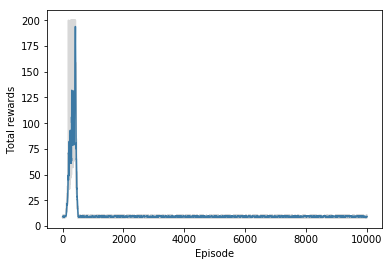

In [26]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

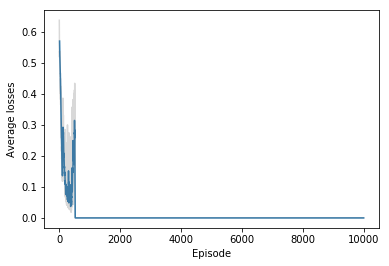

In [27]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.